In [1]:
import os, sys, glob
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize

from tqdm.notebook import tqdm

from utils import prepare_simulation, prepare_data

In [2]:
source_ra = 77.358 # degrees
source_dec = 5.693 # degrees

ra_bins = np.radians(np.linspace(72, 82, 21))
dec_bins = np.radians(np.linspace(0, 10, 21))

In [3]:
sim = prepare_simulation(source_ra, source_dec, # degrees
                           window = 5, # degrees
                           E0 = 1000, # GeV,
                           gamma = 2,
                           time_mean = 57000,
                           time_sigma = 100,
                           simfile = "/data/mjlarson/datasets/ps_tracks/version-003-p02/IC86_2012_MC.npy")

In [4]:
# And grab the data
data = prepare_data()

# Make your histograms. 

We'll use ra and dec binning here...

In [5]:
# We're going to use np.histogram2d instead of pyplot.hist2d
# since we don't need to look at the plots...
data_hist, _, _ = np.histogram2d(data['ra'], data['dec'],
                                 bins = (ra_bins, dec_bins))
signal_hist, _, _ = np.histogram2d(sim['ra'], sim['dec'],
                                   bins = (ra_bins, dec_bins),
                                   weights=sim['probability_weight'])

bg_hist = np.histogram(data['dec'], bins=dec_bins)[0] 
bg_hist = bg_hist/bg_hist.sum() / (len(ra_bins)-1)
bg_hist = bg_hist[None, :]*np.ones_like(data_hist)

# Let's do a simple fit

We believe our data histogram $k$ is some combination of the signal histogram $S$ and background histogram $B$ so that

>   $k = (\hat{N}_b * B) + (\hat{N}_s * S)$
   
with $\hat{N}_b$ representing the number of background events and $\hat{N}_s$ the true number of signal events. We don't actually know the right values of $\hat{N}_b$ and $\hat{N}_s$ yet, though. To find them, let's do a simple $chi^2$ fit with two free parameters $N_b$ and $N_s$. The $chi^2$ fit is defined in terms of the expectation $\lambda(N_b, N_s)$ as

> $\chi^2(N_b, N_s) = \left(\lambda(N_b, N_s) - k\right)^2$  /  $\lambda(N_b, N_s)$

Let's look at the implementation of the expectation and $\chi^2$ below.

In [6]:
def expectation(N_b, bg_hist,
                N_s, signal_hist):
    return N_b*bg_hist + N_s*signal_hist

In [7]:
def chi2(data_hist, 
         N_b, bg_hist, 
         N_s, signal_hist):
    exp_hist = expectation(N_b, bg_hist, 
                           N_s, signal_hist)
    
    with np.errstate(divide='ignore'):
        per_bin_chi2 = ((data_hist-exp_hist)**2 / exp_hist)
        per_bin_chi2[~np.isfinite(per_bin_chi2)] = 0
    return per_bin_chi2.sum()

In [8]:
# And we do the fit using scipy
fit_func = lambda params: chi2(data_hist=data_hist, 
                               N_b=params[0], bg_hist=bg_hist,
                               N_s=params[1], signal_hist=signal_hist)

results = minimize(fit_func, 
                   x0 = [data_hist.sum(), 0.0],
                   bounds = [[0.9*data_hist.sum(), 1.1*data_hist.sum()], 
                              [0, 1000]])

# Take a look at the output numbers

We've fit a value now: N_s. Let's take a look at our best fit values out of the `scipy.optimize.minimize` function.

In [9]:
#print(results)
data_bestfit_chi2 = results.fun
data_bestfit_N_s= results.x[1]

print(f"Found a best-fit of {data_bestfit_N_s} signal events")
print(f"Final chi2 value: {data_bestfit_chi2} with {len(data_hist.ravel())} degrees of freedom")

Found a best-fit of 0.0 signal events
Final chi2 value: 435.9480841063464 with 400 degrees of freedom


# Is this good?

Did we find signal events?  chi2/ndof < 1! But is this good? Is this 
significant? We actually don't know: it's entirely possible that our fit can 
return signal events just by chance. To really be able to tell, we need to be 
able to see how often our fit sees a "signal" like this from background alone.

We do this by producing simulated data (randomizing RA) with N_b=1 and N_s=0. 
We call this simulated a data a "background trial" or, more generically, simply 
a "trial"

>  bg_trial_hist = expectation(N_s=0) = ((N-0) * bg_hist) + (0*signal_hist)

>  bg_trial_hist = bg_hist

At this point, we have two options: we can either use `np.random.poisson` on 
`bg_hist` to get a random sample of events based on the background or we can 
randomize the RA values directly from the data. Let's do the former, since it's
a bit faster.

Let's write a simple function to pick random RA values and return a new "data_hist" 
and redo our fit again.

In [10]:
def make_bg_trial_hist(N=data_hist.sum(), bg_hist=bg_hist):
    return np.random.poisson(N*bg_hist)

In [11]:
trial_hist = make_bg_trial_hist(data_hist.sum(),
                                bg_hist)

fit_func = lambda params: chi2(data_hist=trial_hist, 
                               N_b=params[0], bg_hist=bg_hist,
                               N_s=params[1], signal_hist=signal_hist)

trial_results = minimize(fit_func, 
                         x0 = [data_hist.sum(), 0.0],
                         bounds = [[0.9*data_hist.sum(), 1.1*data_hist.sum()], 
                                   [0, 1000]])  

#print(results)
trial_bestfit_chi2 = trial_results.fun
trial_bestfit_N_s = trial_results.x[1]

print(f"Found a best-fit of {trial_bestfit_N_s} signal events")
print(f"Final chi2 value: {trial_bestfit_chi2} with {len(trial_hist.ravel())} degrees of freedom")

Found a best-fit of 8.837612054081141 signal events
Final chi2 value: 370.53910523538593 with 400 degrees of freedom


# How does this help?

We now have another fit. We know this one doesn't include any signal, so it's
just testing what happens if there were only background. It looks like the fit
can return N_s > 0, even when there's background. We still don't know how often
that happens, though. To figure that out, we need to build a "test statistic"
distribution.

A "test statistic" ("TS") is normally something that you can use to distinguish 
between signal from background. For the moment, let's use the value of N_s as our 
test statistic and write something to build a distribution of TS values from background.

In [12]:
def get_ts_values(data, 
                  bg_hist,
                  signal_hist,
                  bins,
                  n_trials):
    ts_values = []
    for i in tqdm(range(n_trials)):
        trial_hist = make_bg_trial_hist(N=data_hist.sum(), bg_hist=bg_hist)
        fit_func = lambda params: chi2(data_hist=trial_hist, 
                                       N_b=params[0], bg_hist=bg_hist,
                                       N_s=params[1], signal_hist=signal_hist)
        trial_results = minimize(fit_func, 
                                 x0 = [trial_hist.sum(), 0.0],
                                 bounds = [[0.9*trial_hist.sum(), 1.1*trial_hist.sum()], 
                                           [0, 1000]])  
        ts_values.append(trial_results.x[1])
        
    return np.array(ts_values)

In [13]:
bg_trial_ns_values = get_ts_values(data = data, 
                                   bg_hist = bg_hist,
                                   signal_hist = signal_hist,
                                   bins = (ra_bins, dec_bins),
                                   n_trials = 10000)

Our data fit has a pvalue = 1.000e+00
Alternatively, we see 10000.0/10000 background trials more significant than the data.


Text(0, 0.5, 'Number of trials')

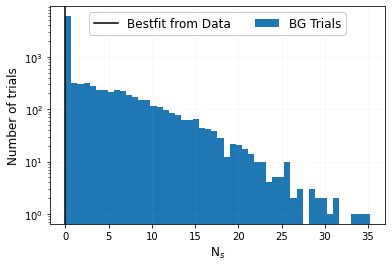

In [14]:
# Print out how rare our best-fit value is in the background distribution!
# This is where we find out how significant our result is!
frac_trials_above_data = (bg_trial_ns_values >= data_bestfit_N_s).sum() / len(bg_trial_ns_values)
print(f"Our data fit has a pvalue = {frac_trials_above_data:4.3e}")
print(f"Alternatively, we see {len(bg_trial_ns_values)*frac_trials_above_data}/{len(bg_trial_ns_values)}"
      " background trials more significant than the data.")

# And plot them along with our original data TS value.
fig, ax = plt.subplots()
_ = ax.hist(bg_trial_ns_values, 
            bins = 50,
            histtype='stepfilled',
            linewidth=3,
            label = 'BG Trials')

# And draw our data TS value.
ax.axvline(data_bestfit_N_s,
           color='k',
           label="Bestfit from Data"
          )

# Make it look nicer.
ax.legend(loc='upper center', ncol=2, fontsize=12, framealpha=1)
ax.grid(alpha=0.1)
ax.set_yscale('log')
ax.set_xlabel(r"N$_s$", fontsize=12)
ax.set_ylabel("Number of trials", fontsize=12)